# **Style Transfer**

## Notes

* Used framework: [PyTorch](https://pytorch.org/)

* To focus only on the style of the output image, *the content image* is always selected as *the input image*. If desired, you can use white noise.

* Used CNN: [VGG-19](https://arxiv.org/pdf/1409.1556.pdf) as simple CNN architecture.

* This project was inspired by one seminar of [Deep Learning School](https://www.dlschool.org/) (spring, 2020)

* All calculations was made using [Colaboratory Google (Colab) ](https://colab.research.google.com/)

# Preparing

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [2]:
%matplotlib inline
from PIL import Image, ImageOps


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Common functions

Image preprocessing

In [5]:
def loader(size):
    return transforms.Compose([
    transforms.Resize(size),  
    transforms.ToTensor()])  

def image_loader(name_file, size):
    image = Image.open(name_file)
    image = (loader(size))(image).unsqueeze(0)
    return image.to(device, torch.float)

Drawing an image from tensor

In [6]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

The same content loss function for every kind of transfer

In [7]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach() # Константа, убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target) # Как-нибудь проинициализировать

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Calculating the gram matrix

In [8]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)

        G = torch.mm(features, features.t())  # compute the gram product

        # 'normalize' the values of the gram matrix
        return G.div(batch_size * h * w * f_map_num)

Normalizing our images as for images that VGG learned from

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [10]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

List of layers after which we will calculate style and content loss

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Building a model

In [12]:
def get_model(cnn, loss_fn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                if type(style_img) == list:
                    target_features = []
                    for st_img in style_img:
                        target_features.append(model(st_img).detach()) 
                    style_loss = loss_fn(target_features)
                else:
                    target_feature = model(style_img).detach()
                    style_loss = loss_fn(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], loss_fn):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [13]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Training function

In [14]:
def run_style_transfer(cnn, loss_fn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=10):
        model, style_losses, content_losses = get_model(cnn, loss_fn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

Defining a pre-trained VGG-19 model

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Read the main images: content, style, input

In [16]:
def get_images(imsize, name_content, name_style):
    content_img = image_loader(name_content,imsize)
    style_img = image_loader(name_style,imsize) 
    input_img = content_img.clone()
    return content_img, style_img, input_img

Save process plot to file: images (input, content, style...)

In [17]:
def show_save_process(images_list, names_list, name_file, save = True, figure_size=(15,15)):
    n = len(images_list)
    assert n == len(names_list), 'images_list and names_list sizes don\'t match'
    plt.figure(figsize=figure_size)
    if n<=3:
        rows, columns = 1, n
    elif n==4:
        rows, columns = 2, 2
    else:
        rows, columns = 2, 3
    for idx, image in enumerate(images_list):
        plt.subplot(rows, columns, idx+1)
        imshow(image, title=names_list[idx])
    if save:
        plt.savefig('images/process/' + name_file, dpi=300)
    plt.show()  

In [18]:
def save_output(output, name):
    out = output.cpu().detach().numpy()
    plt.imsave('images/result/'+name, out[0].transpose(1,2,0)) 

# Usual Style Transfer

$Loss_{style}$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$,

G - gram matrix

In [19]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target) # to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

## Avengers to the 'Scream' style (Edvard Munch)

In [20]:
imsize = (504,806) # size of the content (=input) image

content_img, style_img, input_img = get_images(imsize, name_content="images/content/avengers.jpg", name_style="images/styles/scream.jpg")

In [21]:
output = run_style_transfer(cnn, StyleLoss, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=450, style_weight=100000, content_weight=1)

run [50]:
Style Loss : 20.205547 Content Loss: 16.561258

run [100]:
Style Loss : 6.246119 Content Loss: 14.464428

run [150]:
Style Loss : 3.200836 Content Loss: 13.498169

run [200]:
Style Loss : 2.213272 Content Loss: 13.178889

run [250]:
Style Loss : 1.866869 Content Loss: 12.888660

run [300]:
Style Loss : 1.686929 Content Loss: 12.722863

run [350]:
Style Loss : 1.576228 Content Loss: 12.648315

run [400]:
Style Loss : 1.490409 Content Loss: 12.602535

run [450]:
Style Loss : 1.468622 Content Loss: 12.753159



Let's look at the result

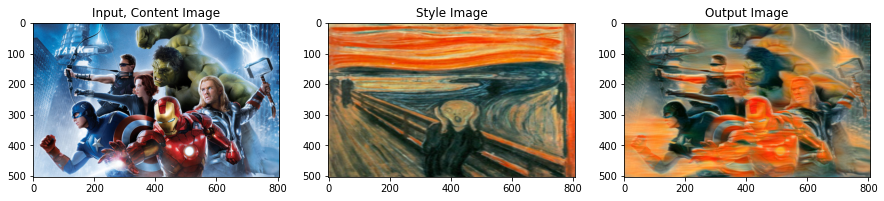

In [22]:
show_save_process([content_img, style_img, output], 
             ['Input, Content Image', 'Style Image', 'Output Image'],
             'usual_style_transfer_avengers.png', figure_size=(15,5))

Save output

In [23]:
save_output(output, 'usual_style_transfer_avengers.png')

## Mona Lisa to the Picasso style (Great Still life on pedestal)

In [24]:
imsize = (603,403) 

content_img, style_img, input_img = get_images(imsize, name_content="images/content/lisa.jpg", name_style="images/styles/picasso.jpg")

In [25]:
output = run_style_transfer(cnn, StyleLoss, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps = 400, style_weight=100000, content_weight=1)

run [50]:
Style Loss : 75.434074 Content Loss: 29.691845

run [100]:
Style Loss : 20.586630 Content Loss: 29.431786

run [150]:
Style Loss : 9.111857 Content Loss: 28.008488

run [200]:
Style Loss : 5.116404 Content Loss: 27.039461

run [250]:
Style Loss : 3.539196 Content Loss: 26.170122

run [300]:
Style Loss : 2.819673 Content Loss: 25.679813

run [350]:
Style Loss : 2.966542 Content Loss: 25.270607

run [400]:
Style Loss : 2.146797 Content Loss: 25.181166



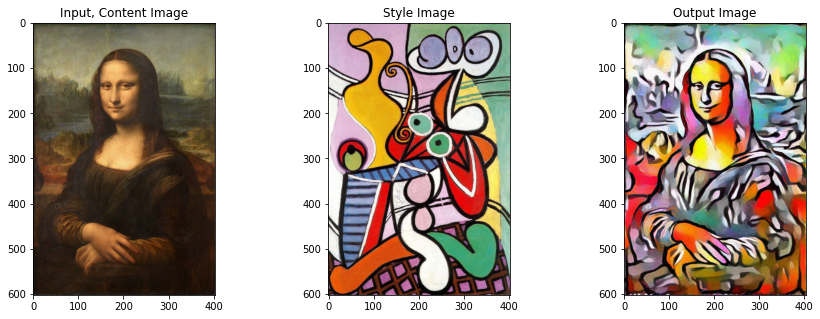

In [26]:
show_save_process([content_img, style_img, output], 
             ['Input, Content Image', 'Style Image', 'Output Image'],
             'usual_style_transfer_mona_lisa.png', figure_size=(15,5))

save_output(output, 'usual_style_transfer_mona_lisa.png')

## Novosibirsk day picture to the night picture

In [27]:
im_size = (686, 996)

content_img, style_img, input_img = get_images(im_size, name_content="images/content/nsk.jpg", name_style="images/styles/night.jpg")

In [28]:
output = run_style_transfer(cnn, StyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 242.431030 Content Loss: 20.384815

run [100]:
Style Loss : 180.149597 Content Loss: 25.360725

run [150]:
Style Loss : 251.753540 Content Loss: 32.636803

run [200]:
Style Loss : 121.163452 Content Loss: 33.168118

run [250]:
Style Loss : 50.455997 Content Loss: 36.446320

run [300]:
Style Loss : 45.877048 Content Loss: 34.874268

run [350]:
Style Loss : 9.069928 Content Loss: 28.064409

run [400]:
Style Loss : 27.745951 Content Loss: 25.523203

run [450]:
Style Loss : 5.275138 Content Loss: 22.928743

run [500]:
Style Loss : 4.381112 Content Loss: 21.809996



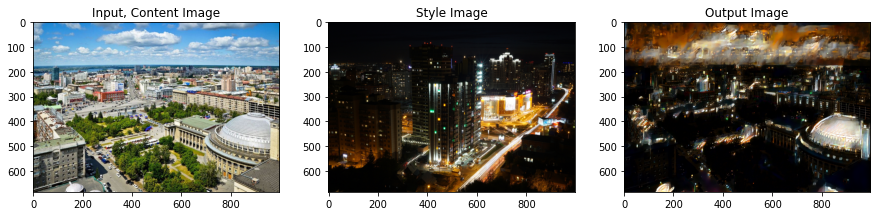

In [29]:
show_save_process([content_img, style_img, output], 
             ['Input, Content Image', 'Style Image', 'Output Image'],
             'usual_style_transfer_night_nsk.png', figure_size=(15,5))

save_output(output, 'usual_style_transfer_night_nsk.png')

## Novosibirsk picture to the Van Gog style (The Starry Night)

In [30]:
im_size = (686, 996)

content_img, style_img, input_img = get_images(im_size, name_content="images/content/nsk.jpg", name_style="images/styles/van gog.jpg")

In [31]:
output = run_style_transfer(cnn, StyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 61.627987 Content Loss: 21.332066

run [100]:
Style Loss : 19.252918 Content Loss: 20.148239

run [150]:
Style Loss : 8.642901 Content Loss: 17.416639

run [200]:
Style Loss : 5.047252 Content Loss: 15.279873

run [250]:
Style Loss : 3.305623 Content Loss: 14.027346

run [300]:
Style Loss : 2.333029 Content Loss: 13.190348

run [350]:
Style Loss : 1.759848 Content Loss: 12.645875

run [400]:
Style Loss : 1.403967 Content Loss: 12.272015

run [450]:
Style Loss : 1.193495 Content Loss: 12.000866

run [500]:
Style Loss : 1.061899 Content Loss: 11.799715



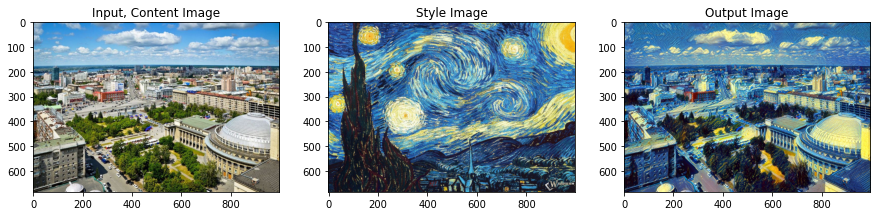

In [32]:
show_save_process([content_img, style_img, output], 
             ['Input, Content Image', 'Style Image', 'Output Image'],
             'usual_style_transfer_van_gog_nsk.png', figure_size=(15,5))

save_output(output, 'usual_style_transfer_van_gog_nsk.png')

In [33]:
out = output.cpu().detach().numpy()
plt.imsave('images/result/usual_style_transfer_van_gog_nsk.png', out[0].transpose(1,2,0))

# Mask Style Transfer

Resizing the mask to *size*

In [34]:
def get_necessary_mask(size):
            mask_pil = transforms.ToPILImage()(mask_img[0].cpu())
            return transforms.Compose([
                              transforms.Resize(size),
                              transforms.ToTensor()])(mask_pil).to(device, torch.float)

New style loss class

In [35]:
class MaskStyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(MaskStyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)
        
        def forward(self, input):
            mask_resized = get_necessary_mask((input.shape[2], input.shape[3]))
            mask = torch.stack([mask_resized[0]] * input.shape[1])
            c, h, w = mask.shape
            mask = mask.view(1, c, h, w)
            input = torch.mul(input, mask)
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

## Mona Lisa with mask to the Picasso style

In [36]:
imsize = (861, 576)

content_img, style_img, input_img = get_images(imsize, name_content="images/content/lisa.jpg", name_style="images/styles/picasso.jpg")
mask_img = image_loader("images/masks/lisa mask.jpg", imsize)

In [37]:
output = run_style_transfer(cnn, MaskStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 133.834900 Content Loss: 7.493815

run [100]:
Style Loss : 86.322083 Content Loss: 7.936949

run [150]:
Style Loss : 67.586632 Content Loss: 7.903872

run [200]:
Style Loss : 59.575123 Content Loss: 7.625373

run [250]:
Style Loss : 53.502213 Content Loss: 7.646592

run [300]:
Style Loss : 49.427788 Content Loss: 7.813220

run [350]:
Style Loss : 46.471485 Content Loss: 7.579979

run [400]:
Style Loss : 44.741219 Content Loss: 7.283534

run [450]:
Style Loss : 43.936790 Content Loss: 7.096038

run [500]:
Style Loss : 43.376362 Content Loss: 7.045761



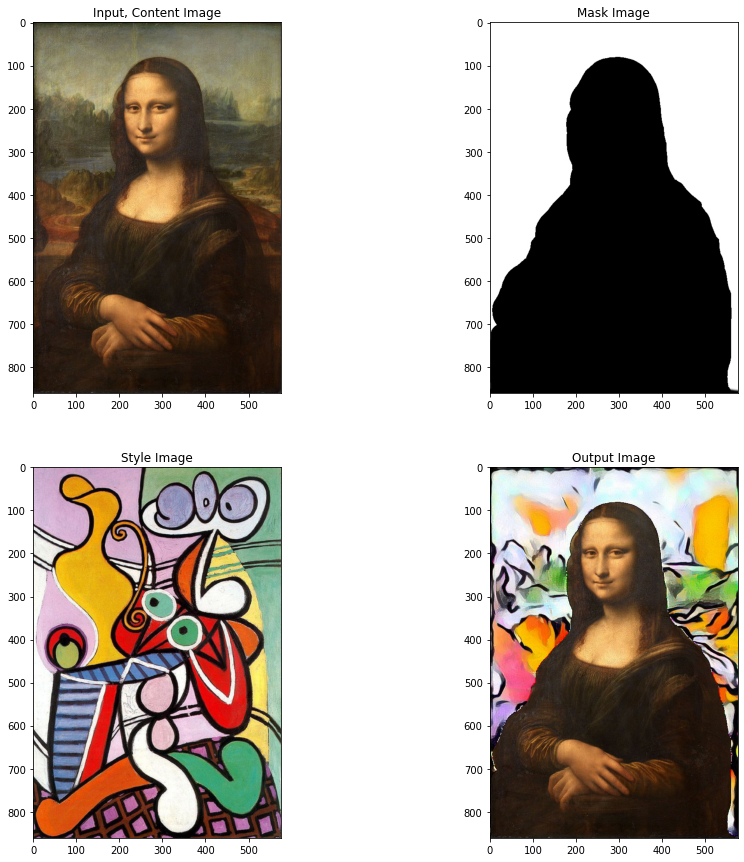

In [38]:
show_save_process([content_img, mask_img, style_img, output], 
             ['Input, Content Image', 'Mask Image', 'Style Image', 'Output Image'],
             'mask_style_transfer_lisa.png')

In [39]:
save_output(output, 'mask_style_transfer_lisa.png')

## Summer Forest to Autumn Forest

In [40]:
imsize = (669, 1000)

content_img, style_img, input_img = get_images(imsize, name_content="images/content/forest.jpg", name_style="images/styles/autumn.jpg")
mask_img = image_loader("images/masks/forest mask.jpg", im_size)

In [41]:
output = run_style_transfer(cnn, MaskStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 190.252533 Content Loss: 18.724201

run [100]:
Style Loss : 109.013168 Content Loss: 19.152969

run [150]:
Style Loss : 72.995995 Content Loss: 18.108189

run [200]:
Style Loss : 60.319782 Content Loss: 17.076527

run [250]:
Style Loss : 56.512932 Content Loss: 14.769536

run [300]:
Style Loss : 53.295689 Content Loss: 13.315792

run [350]:
Style Loss : 51.941711 Content Loss: 12.432280

run [400]:
Style Loss : 51.108589 Content Loss: 12.005750

run [450]:
Style Loss : 50.527016 Content Loss: 11.832088

run [500]:
Style Loss : 51.984543 Content Loss: 11.720572



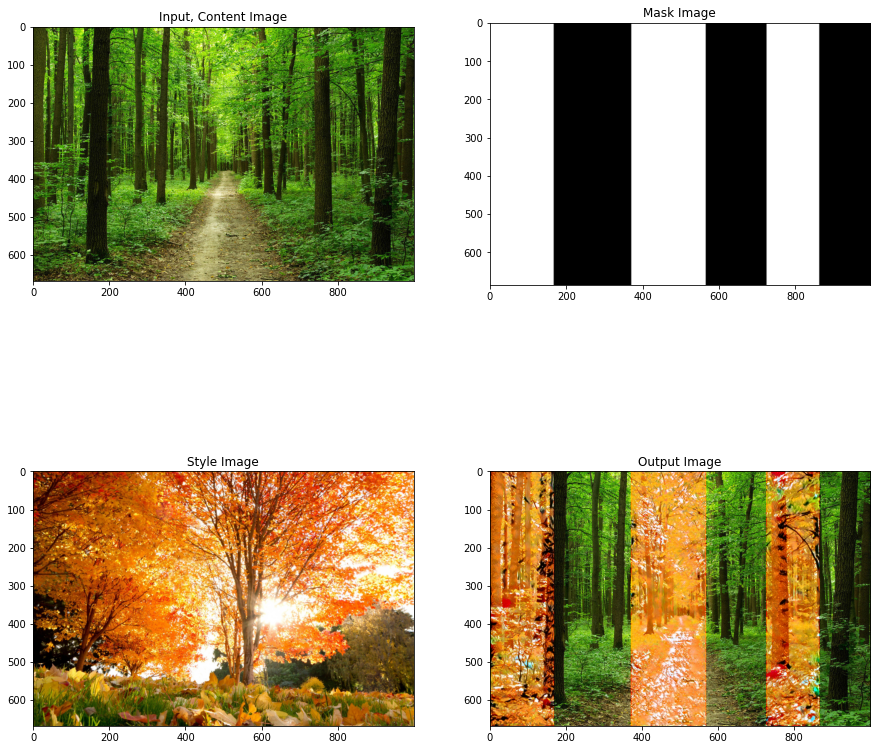

In [42]:
show_save_process([content_img, mask_img, style_img, output], 
             ['Input, Content Image', 'Mask Image', 'Style Image', 'Output Image'],
             'mask_style_transfer_forest.png')

In [43]:
save_output(output, 'mask_style_transfer_forest.png')

# Double Style Transfer

In [44]:
class DoubleStyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(DoubleStyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature[0]).detach()
            self.target2 = gram_matrix(target_feature[1]).detach()
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something
            
        def forward(self, input):
            G = gram_matrix(input)
            self.loss = 0.5*(F.mse_loss(G, self.target1) + 0.5*F.mse_loss(G, self.target2))
            return input

## Novosibirsk picture to Van Gog (The Starry Night) and Ajvazovskij (The Ninth Wave) style

In [45]:
im_size = (686, 996)

content_img, style_1_img, input_img = get_images(im_size, name_content="images/content/nsk.jpg", name_style="images/styles/van gog.jpg")
style_2_img = image_loader("images/styles/ajvazovskij.jpg", im_size) 

In [46]:
output = run_style_transfer(cnn, DoubleStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, [style_1_img, style_2_img], input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 9039.135742 Content Loss: 17.193365

run [100]:
Style Loss : 9004.681641 Content Loss: 15.910238

run [150]:
Style Loss : 8994.003906 Content Loss: 14.272085

run [200]:
Style Loss : 8990.076172 Content Loss: 12.780579

run [250]:
Style Loss : 8988.444336 Content Loss: 11.630108

run [300]:
Style Loss : 8987.557617 Content Loss: 10.853194

run [350]:
Style Loss : 8986.968750 Content Loss: 10.327478

run [400]:
Style Loss : 8986.562500 Content Loss: 9.920802

run [450]:
Style Loss : 8986.316406 Content Loss: 9.606629

run [500]:
Style Loss : 8986.132812 Content Loss: 9.347473



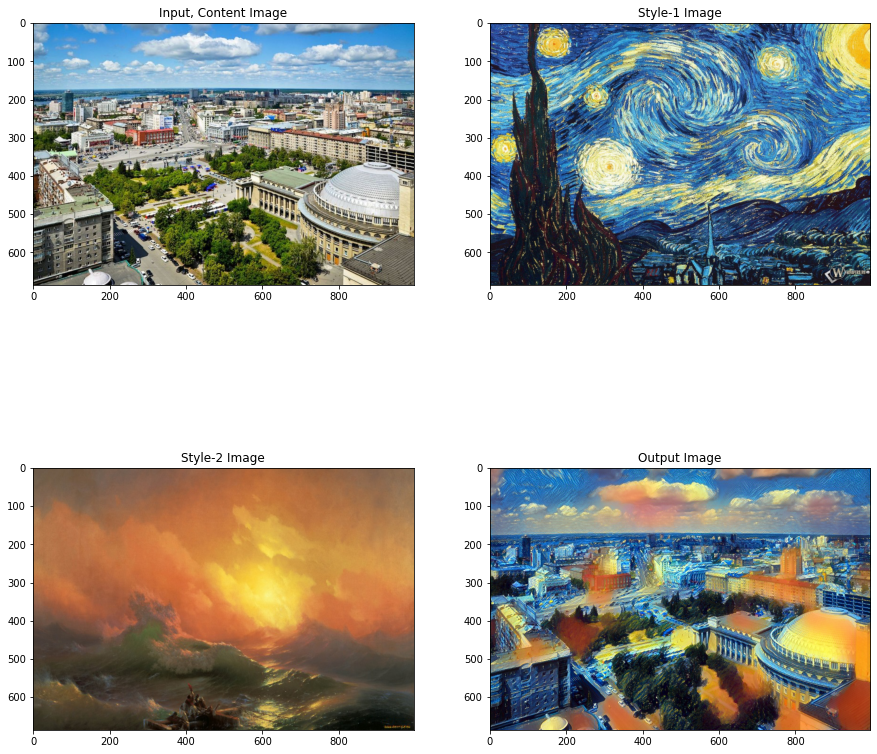

In [47]:
show_save_process([content_img, style_1_img, style_2_img, output], 
             ['Input, Content Image', 'Style-1 Image', 'Style-2 Image', 'Output Image'],
             'double_style_transfer_van_gog_ajv_nsk.png')

In [48]:
save_output(output, 'double_style_transfer_van_gog_ajv_nsk.png')

## Forest image to autumn and winter styles

In [49]:
im_size = (669, 1000)

content_img, style_1_img, input_img = get_images(im_size, name_content="images/content/forest.jpg", name_style="images/styles/autumn.jpg")
style_2_img = image_loader("images/styles/winter.jpeg", im_size) 

In [50]:
output = run_style_transfer(cnn, DoubleStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, [style_1_img, style_2_img], input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 6162.363281 Content Loss: 29.566425

run [100]:
Style Loss : 6026.137695 Content Loss: 30.797443

run [150]:
Style Loss : 5975.826172 Content Loss: 30.469881

run [200]:
Style Loss : 5944.974121 Content Loss: 29.825994

run [250]:
Style Loss : 5930.465332 Content Loss: 27.003080

run [300]:
Style Loss : 5920.957031 Content Loss: 25.634348

run [350]:
Style Loss : 5914.533203 Content Loss: 24.011713

run [400]:
Style Loss : 5910.828613 Content Loss: 22.402864

run [450]:
Style Loss : 5912.516113 Content Loss: 20.981390

run [500]:
Style Loss : 5905.256836 Content Loss: 20.243856



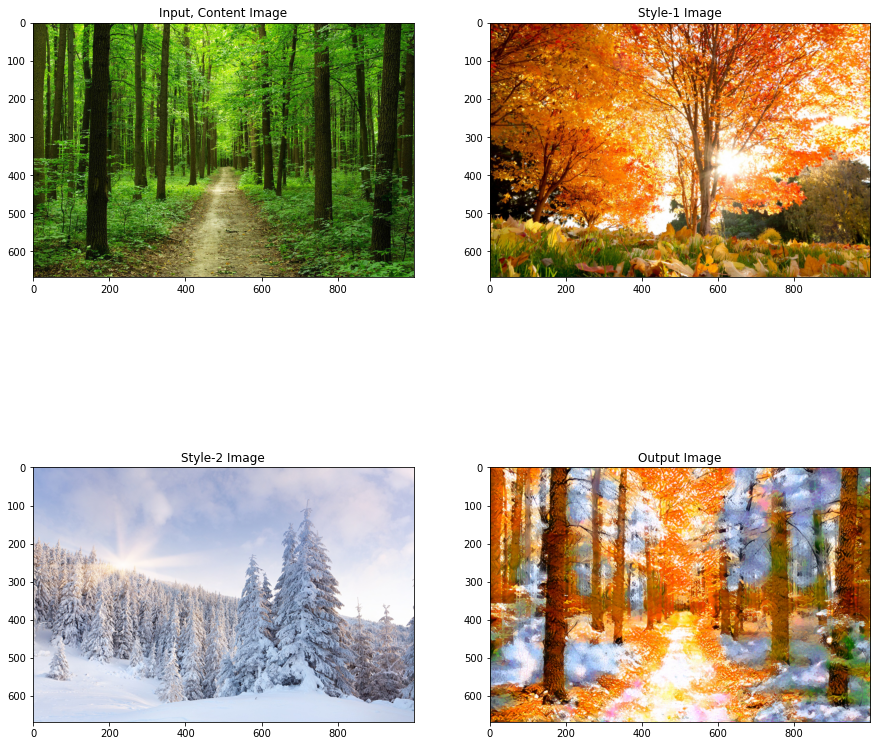

In [51]:
show_save_process([content_img, style_1_img, style_2_img, output], 
             ['Input, Content Image', 'Style-1 Image', 'Style-2 Image', 'Output Image'],
             'double_style_transfer_autumn_winter_forest.png')

In [52]:
save_output(output, 'double_style_transfer_autumn_winter_forest.png')

# Double Mask Style Transfer

Resizing the mask and the inverted mask to *size* 

In [53]:
def get_necessary_masks(size):
            mask_pil = transforms.ToPILImage()(mask_img[0].cpu())
            transf = transforms.Compose([
                              transforms.Resize(size),
                              transforms.ToTensor()])
            mask_pil_c = mask_pil.convert('L')
            inverted_mask_pil = ImageOps.invert(mask_pil_c)
            inverted_mask = transf(inverted_mask_pil)
            return transf(mask_pil).to(device, torch.float), inverted_mask.to(device, torch.float)

In [54]:
class DoubleMaskStyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(DoubleMaskStyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature[0]).detach()
            self.target2 = gram_matrix(target_feature[1]).detach()
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something

        def forward(self, input):
            resized_mask, resized_inverse_mask = get_necessary_masks((input.shape[2], input.shape[3]))
            mask = torch.stack([resized_mask[0]] * input.shape[1])
            inv_mask = torch.stack([resized_inverse_mask[0]] * input.shape[1])
            c, h, w = mask.shape
            mask = mask.view(1, c, h, w)
            inv_mask = inv_mask.view(1, c, h, w)
            input1 = torch.mul(input, mask)
            input2 = torch.mul(input, inv_mask)
            G1 = gram_matrix(input1)
            G2 = gram_matrix(input2)
            self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
            return input

## Novosibirsk picture to Van Gog (The Starry Night) and Ajvazovskij (The Ninth Wave) style with mask

In [55]:
im_size = (686, 996)

content_img, style_1_img, input_img = get_images(im_size, name_content="images/content/nsk.jpg", name_style="images/styles/van gog.jpg")
style_2_img = image_loader("images/styles/ajvazovskij.jpg", im_size) 
mask_img = image_loader("images/masks/nsk mask.png", im_size)

In [56]:
output = run_style_transfer(cnn, DoubleMaskStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, [style_1_img, style_2_img], input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 340.573181 Content Loss: 38.303200

run [100]:
Style Loss : 112.939476 Content Loss: 39.339455

run [150]:
Style Loss : 71.832954 Content Loss: 36.197876

run [200]:
Style Loss : 57.329693 Content Loss: 34.605213

run [250]:
Style Loss : 50.796745 Content Loss: 33.598591

run [300]:
Style Loss : 47.235687 Content Loss: 32.675617

run [350]:
Style Loss : 46.759747 Content Loss: 31.941631

run [400]:
Style Loss : 47.361401 Content Loss: 31.669134

run [450]:
Style Loss : 48.159729 Content Loss: 32.446434

run [500]:
Style Loss : 50.017769 Content Loss: 32.759720



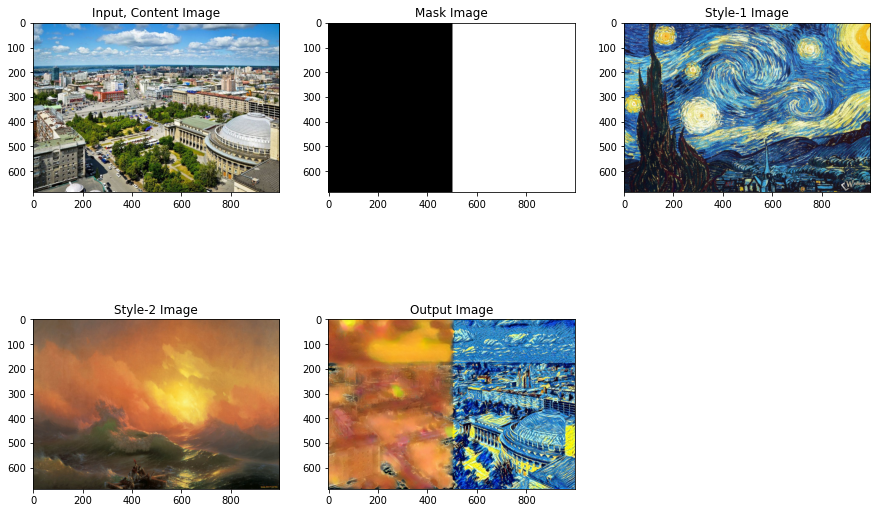

In [57]:
show_save_process([content_img, mask_img, style_1_img, style_2_img, output], 
             ['Input, Content Image', 'Mask Image', 'Style-1 Image', 'Style-2 Image', 'Output Image'],
             'double_mask_style_transfer_van_gog_ajv_nsk.png', figure_size=(15,10))

In [58]:
save_output(output, 'double_mask_style_transfer_van_gog_ajv_nsk.png')

## Cats to drawing style, background to the 'Scream' style 

In [59]:
im_size = (513, 821)

content_img, style_1_img, input_img = get_images(im_size, name_content="images/content/cats.jpg", name_style="images/styles/drawing cat.jpg")
style_2_img = image_loader("images/styles/scream.jpg", im_size) 
mask_img = image_loader("images/masks/cats mask.png", im_size)

In [60]:
output = run_style_transfer(cnn, DoubleMaskStyleLoss, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, [style_1_img, style_2_img], input_img, num_steps=500, style_weight=1000000, content_weight=1)

run [50]:
Style Loss : 300.159271 Content Loss: 17.893528

run [100]:
Style Loss : 139.519226 Content Loss: 19.120478

run [150]:
Style Loss : 96.586441 Content Loss: 19.556086

run [200]:
Style Loss : 83.666794 Content Loss: 19.614044

run [250]:
Style Loss : 75.844872 Content Loss: 19.537371

run [300]:
Style Loss : 72.881355 Content Loss: 19.605568

run [350]:
Style Loss : 298.712738 Content Loss: 22.048836

run [400]:
Style Loss : 70.350639 Content Loss: 20.328634

run [450]:
Style Loss : 164.042694 Content Loss: 20.589815

run [500]:
Style Loss : 74.806274 Content Loss: 20.737385



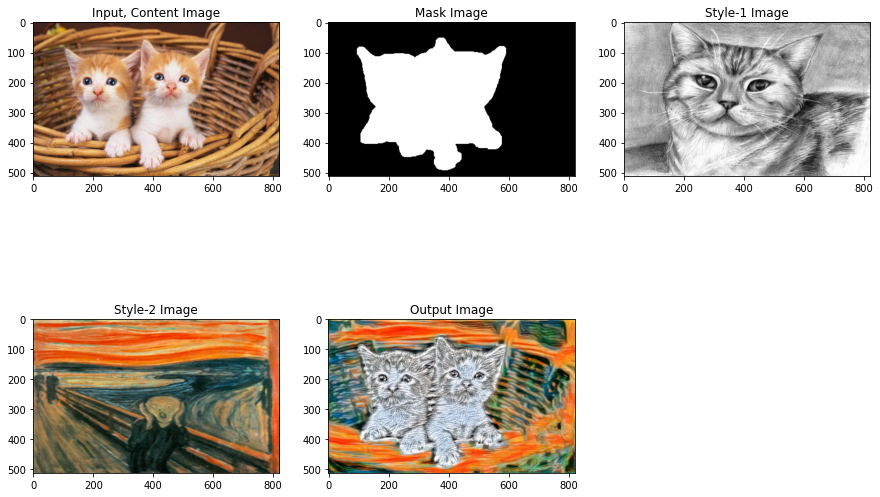

In [61]:
show_save_process([content_img, mask_img, style_1_img, style_2_img, output], 
             ['Input, Content Image', 'Mask Image', 'Style-1 Image', 'Style-2 Image', 'Output Image'],
             'double_mask_style_transfer_cats.png', figure_size=(15,10))

In [62]:
save_output(output, 'double_mask_style_transfer_cats.png')